In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

# Override/set credentials in env var
os.environ['CWD'] = str(Path(os.getcwd()).parent)

# Base paths
cwd = Path(os.environ['CWD'])
dir_data = cwd / 'data'


import numpy as np
from PIL import Image

In [2]:
from faker import Faker
Faker.seed(288)
fake = Faker(
#     [
#     'it_IT',
#     'en_US',
#     'es_ES',
#     'en_CA'
#     ]
)
import pandas as pd

db1 = pd.DataFrame([fake.profile() for _ in range(20000)])

In [4]:
# Add current_location
# Remove fields randomly 
db1.head(5)

,job,company,ssn,residence,current_location,blood_group,website,username,name,sex,address,mail,birthdate
0,Herbalist,Norton-Castillo,049-66-7039,"9727 Todd Unions\nStaceyville, MN 41947","(-55.9124455, 32.664240)",AB-,"[https://butler.info/, http://johnson.net/]",shannon98,Amanda Arroyo,F,"0751 Samantha Walk Apt. 650\nChenfort, SC 04033",schroedermelissa@yahoo.com,1970-02-15
1,Outdoor activities/education manager,Bowman-Jensen,067-35-7522,Unit 0723 Box 5155\nDPO AP 51042,"(19.764603, 67.662516)",A-,"[http://www.parker.com/, https://www.lowe.info/]",nathaniel53,Victoria Brown,F,"787 Alexander Road\nPort Leslieborough, VA 53325",tylermonica@hotmail.com,1926-06-02
2,"Chemist, analytical","Wilkerson, Guerrero and Mason",219-24-2883,"878 Charles Mountain\nNorth Loriton, LA 14794","(-57.0475775, 4.464624)",AB+,"[https://www.salinas.com/, https://kennedy.com/]",uperry,Amy Henry,F,"706 Sarah Lakes Apt. 421\nSouth Jeremy, AR 49313",pdelgado@hotmail.com,2016-02-25
3,"Geneticist, molecular",Simmons-Martinez,383-07-2464,"993 Boyd Throughway\nNew Paul, WI 12980","(-6.687283, 110.936355)",B+,"[http://wilson-cohen.com/, https://riggs-alvar...",qrobertson,Christopher Curtis,M,"7274 Bird Canyon Suite 720\nValentinechester, ...",patrick79@gmail.com,1966-10-29
4,Structural engineer,"Castillo, Clark and Kemp",296-65-4080,"35200 Miller Mountain Apt. 251\nRileyville, MO...","(-56.0627945, 64.691982)",B+,[https://baker.com/],kfitzgerald,Kevin Vargas,M,"1310 Anderson Fork Apt. 598\nBrandonbury, WV 3...",rickytaylor@hotmail.com,1968-06-09


In [3]:
pd.options.mode.chained_assignment = None
np.random.seed(288)


db2 = db1[['job', 'address', 'name']]



import re
def _split(txt):
    return [x.strip() for x in re.split('-|\s| and |,', txt) if x.strip() != '']

# _split('Wilson, Sanchez and Pearson')

db2['job'] = db2['job'].apply(lambda txt: 
    np.random.choice(_split(txt))
)

db2['name'] = db2['name'].apply(lambda txt: 
    np.random.choice(_split(txt))
)

db2['address'] = db2['address'].apply(lambda txt: 
    ' '.join(np.random.choice(_split(txt), size=min(2, len(_split(txt))), replace=False)) # Keep 2 tokens when possible, otherwise 1
)


import string

def _add_char_noise(txt, p=0.2, noise_set_chars=[c for c in string.ascii_lowercase + string.digits]):
    txt_noise = ''
    for c in txt:
        if np.random.rand() < p:
            txt_noise += np.random.choice(noise_set_chars)
        else:
            txt_noise += c
    return txt_noise


from functools import partial
P_NOISE_CHAR = 0.1
f_add_char_noise = partial(_add_char_noise, p=P_NOISE_CHAR)



db2['job'] = db2['job'].apply(f_add_char_noise)
db2['address'] = db2['address'].apply(f_add_char_noise)
db2['name'] = db2['name'].apply(f_add_char_noise)


_prime = '′'
d_name_map_c1c2 = {k:k+_prime for k in ['name', 'address', 'job']}
db2 = db2.rename(columns=d_name_map_c1c2)

In [54]:
def _random_swap_columns(row, p):
    c1, c2 = np.random.choice(row.index, 2, replace=False)
    aux = row[c1]
    row[c1] = row[c2]
    row[c2] = aux
    return row

In [59]:
def _random_set_empty_column(row, p):
    c = np.random.choice(row.index)
    row[c] = ''
    return row

In [52]:
db2.iloc[0]

index                12044
job′             Financ3al
address′    3082 Jamestown
name′             Cristina
Name: 0, dtype: object

In [60]:
_random_set_empty_column(db2.iloc[0], p=1)

index                12044
job′             Financ3al
address′    3082 Jamestown
name′                     
Name: 0, dtype: object

In [4]:
with pd.option_context('max.colwidth', None):
    display(db1[['name', 'address', 'job']].head())

,name,address,job
0,Amanda Arroyo,"0751 Samantha Walk Apt. 650\nChenfort, SC 04033",Herbalist
1,Victoria Brown,"787 Alexander Road\nPort Leslieborough, VA 53325",Outdoor activities/education manager
2,Amy Henry,"706 Sarah Lakes Apt. 421\nSouth Jeremy, AR 49313","Chemist, analytical"
3,Christopher Curtis,"7274 Bird Canyon Suite 720\nValentinechester, SC 19114","Geneticist, molecular"
4,Kevin Vargas,"1310 Anderson Fork Apt. 598\nBrandonbury, WV 31931",Structural engineer


In [5]:
# Use scann

db2[d_name_map_c1c2.values()].head()

,name′,address′,job′
0,Amanda,0751 Samantha,Herbasist
1,Brotn,Leslieborsugh Alexander,manaaer
2,Henry,SarahyS8uth,6nalytical
3,Curtis,7274 SC,Genetihdst
4,Vargps,Apt. WV,engineer


In [6]:
# missing rows + shuffle
db2 = db2.sample(frac=0.5, random_state=288).reset_index()

In [17]:
db2

,index,job′,address′,name′
0,12044,Financ3al,3082 Jamestown,Cristina
1,9554,Doplomatic,cA Suite,Timothy
2,3271,1nio7,7urgsy881yu,Edwards
3,3956,Osteopath,688 4907,Shyrry
4,15654,Conservato1,Lake Estyte,Hughes
...,...,...,...,...
9995,8447,Sub,dr Chridtopher,tavarro
9996,7513,Arhhitrlt,Diane GA,Dors4y
9997,7698,Product,48238 Jamestdn,8ordan
9998,17569,Prese9ter,Nv 744,Whitj


In [7]:
# Toni: reduce dim

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='char_wb',
                        ngram_range=(1, 5),
                        max_df=0.7,
                        min_df=15,
                        max_features=100000)

In [8]:
X = np.concatenate([
    [str(x) for x in db1.to_numpy().flatten()],
    [str(x) for x in db2.to_numpy().flatten()]
])
tfidf.fit(X)
len(tfidf.vocabulary_)

71341

In [1]:
# from sklearn.metrics.pairwise import cosine_similarity
# l_d_sim = []
# for c1 in db1.columns:
#     for c2 in db2.columns:
#         X1 = tfidf.transform([str(x) for x in db1[c1].values]).astype(np.float32) # cast to np.float32 to avoid mem issues in cosine_sim mat
#         X2 = tfidf.transform([str(x) for x in db2[c2].values]).astype(np.float32)
#         M = cosine_similarity(X1, X2)
#         max_sim_c1c2 = M.max(axis=1).mean()
#         max_sim_c2c1 = M.max(axis=0).mean()
#         max_sim_mean = np.mean([max_sim_c1c2, max_sim_c2c1])
#         l_d_sim.append({
#             'c1': c1,
#             'c2': c2,
#             'sim': max_sim_mean
#         })
# #         print(f'Similarity index between DB1({c1}) and DB2({c2}): {max_sim_c1c2}')
# df_sim = pd.DataFrame(l_d_sim).sort_values('sim', ascending=False)


# TO_MATCH = ["name'", "company'", "address'"]
# matched = set()
# rows_kept = []

# for _, row in df_sim.iterrows():
#     c1 = row['c1']
#     c2 = row['c2']
#     if (c1 in matched or c2 in matched)\
#     or (c1 not in TO_MATCH and c2 not in TO_MATCH):
#         continue
#     else:
#         matched = matched.union(set([c1, c2]))
#         rows_kept.append(row)


# df_c1c2 = pd.DataFrame(rows_kept)

# d_c1c2 = df_c1c2.set_index('c1')['c2'].to_dict()
# d_c1c2

# Rows matching

In [9]:
from scipy.sparse import vstack, hstack
def vectorize_df_ordered_cols(df):
    vectorized_tfidf = np.vectorize(lambda x: tfidf.transform([x]))
    db_mat = df.to_numpy()
    X_db = vectorized_tfidf(db_mat)
    X_db = [hstack(row) for row in X_db]
    X_db = vstack(X_db)
    return X_db

In [10]:
X_db1 = vectorize_df_ordered_cols(db1[d_name_map_c1c2.keys()]).astype(np.float32)
X_db2 = vectorize_df_ordered_cols(db2[d_name_map_c1c2.values()]).astype(np.float32)

In [36]:
X_db1

<20000x214851 sparse matrix of type '<class 'numpy.float32'>'
	with 5308095 stored elements in COOrdinate format>

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
M_rowsim = cosine_similarity(X_db1, X_db2)

matching_row_in_db2 = M_rowsim.argmax(axis=1)
matching_row_in_db2_sim = M_rowsim.max(axis=1)

db1['matching_row_in_db2'] = matching_row_in_db2
db1['sim'] = matching_row_in_db2_sim

In [12]:
list_top5 = []
for row in M_rowsim:
    list_top5.append(row.argsort()[::-1][:5])
    
matching_row_in_db2_top5 = np.array(list_top5).astype(np.uint16) # WARNING FOR INDICES HIGHER THAN 65k!!!!!!!!!

# Alternative
# matching_row_in_db2_top5 = M_rowsim.argsort(axis=1)[:,:5]

In [19]:
db1['matching_row_in_db2_top5'] = [row for row in matching_row_in_db2_top5]

In [27]:
db1[list(d_c1c2.keys())+['matching_row_in_db2']]

,name,company,address,matching_row_in_db2
0,Amanda Arroyo,Norton-Castillo,"0751 Samantha Walk Apt. 650\nChenfort, SC 04033",6944
1,Victoria Brown,Bowman-Jensen,"787 Alexander Road\nPort Leslieborough, VA 53325",7225
2,Amy Henry,"Wilkerson, Guerrero and Mason","706 Sarah Lakes Apt. 421\nSouth Jeremy, AR 49313",7709
3,Christopher Curtis,Simmons-Martinez,"7274 Bird Canyon Suite 720\nValentinechester, ...",3589
4,Kevin Vargas,"Castillo, Clark and Kemp","1310 Anderson Fork Apt. 598\nBrandonbury, WV 3...",8896
...,...,...,...,...
19995,Jessica Scott,"Lindsey, Thompson and Sparks","962 Erica Trail Apt. 657\nDavisberg, MN 17198",9944
19996,Kristin Rowe,Harris-Murray,"40475 Carl Shores Suite 857\nAngelatown, MA 24891",9612
19997,Anthony Collins,Ochoa Group,"979 Shannon Forks\nAliciaburgh, IL 04776",7115
19998,John Lopez,Moran Ltd,"53500 Roy Rest Apt. 425\nNorth April, WI 41629",7636


In [ ]:
# Slide: Not noisy vs correspondent noisy

In [ ]:
# Ruido2: Falta algun campo
# Ruido3: Swap campo
# Rendimiento SCANN

In [ ]:
db2

In [14]:
db2[db2['index'] == 0]

,index,company',address',name'
6944,0,Nortoz,Cmenfort 65s Samantha,Amaida


In [28]:
db2

,index,noise_cmpny,noise_addr,noise_nm
0,12044,Cook,Sg,Barnete
1,9554,PLC,Fr4ncomouth,Garrett
2,3271,Mejia,88120,Lisa
3,3956,Casey,Justinchester,Watsop
4,15654,Gabqett,6403o,Hugh5s
...,...,...,...,...
9995,8447,Mann,Pl,Bvenda
9996,7513,Kelly,Porh,Dorse3
9997,7698,Hern,297,Jxrd7n
9998,17569,Holmes,Gateway,1hite


In [22]:
df_row_matches = pd.merge(
    left=db1.reset_index()[['index', 'matching_row_in_db2', 'company', 'address', 'name', 'sim', 'matching_row_in_db2_top5']],
    right=db2.reset_index()[['level_0', 'index'] + list(d_name_map_c1c2.values())],
    left_on='index',
    right_on='index'
)

In [ ]:
# Toni: Top5acc instead top1acc

In [29]:
# NO THR
df_row_matches['high_conf'] = df_row_matches['sim'] > 0

# THR LEAVING OUT % OF SAMPLES
# df_row_matches['high_conf'] = df_row_matches['sim'] > df_row_matches['sim'].quantile(0.3)


df_row_matches['match_correct'] = df_row_matches['matching_row_in_db2'] == df_row_matches['level_0']
pd.crosstab(df_row_matches['high_conf'], df_row_matches['match_correct'], normalize='index')

match_correct,False,True
high_conf,,
True,0.1445,0.8555


In [38]:
# Top3 acc
df_row_matches['match_correct_top3'] = df_row_matches.apply(lambda row: row['level_0'] in row['matching_row_in_db2_top5'][:3], axis=1)
pd.crosstab(df_row_matches['high_conf'], df_row_matches['match_correct_top3'], normalize='index')

match_correct_top3,False,True
high_conf,,
True,0.0651,0.9349


In [39]:
# Top5 acc
df_row_matches['match_correct_top5'] = df_row_matches.apply(lambda row: row['level_0'] in row['matching_row_in_db2_top5'], axis=1)
pd.crosstab(df_row_matches['high_conf'], df_row_matches['match_correct_top5'], normalize='index')

match_correct_top5,False,True
high_conf,,
True,0.0468,0.9532


In [104]:
fake.profile()

{'job': 'Health visitor',
 'company': 'Barnett, Lawrence and Moore',
 'ssn': '857-54-8850',
 'residence': '818 Mcdonald Ridges\nNorth Shawnton, HI 81397',
 'current_location': (Decimal('10.094721'), Decimal('-31.097598')),
 'blood_group': 'O-',
 'website': ['http://www.wright-leblanc.info/',
  'https://www.anderson-rowe.com/'],
 'username': 'vsanchez',
 'name': 'Kathleen Garcia',
 'sex': 'F',
 'address': '2681 Carter Gateway Apt. 941\nNorth Shelby, DE 75383',
 'mail': 'thomasjackson@gmail.com',
 'birthdate': datetime.date(1939, 8, 12)}

In [ ]:
!pip install scann

     |████████████████████████████████| 10.7 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 497.5 MB 80 kB/s  eta 0:00:013    |████▍                           | 68.0 MB 11.9 MB/s eta 0:00:36     |████▉                           | 75.7 MB 11.9 MB/s eta 0:00:36     |████████▋                       | 133.6 MB 21.9 MB/s eta 0:00:17     |█████████                       | 141.4 MB 6.0 MB/s eta 0:01:00     |█████████▊                      | 150.4 MB 7.2 MB/s eta 0:00:49     |██████████████▏                 | 220.5 MB 13.8 MB/s eta 0:00:21     |███████████████▊                | 244.4 MB 9.6 MB/s eta 0:00:27     |████████████████▏               | 251.6 MB 15.5 MB/s eta 0:00:16     |████████████████▌               | 256.5 MB 15.5 MB/s eta 0:00:16     |█████████████████               | 264.2 MB 5.4 MB/s eta 0:00:44     |█████████████████████▎          | 330.6 MB 8.9 MB/s eta 0:00:19     |███████████████████████         | 357.5 MB 9.8 MB/s eta 0:00:15     |███████████████████████▌

  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:


In [154]:
sample_rows = db1.sample(7)
with pd.option_context('max.colwidth', None):
    display(sample_rows[['residence']])

,residence
4745,"1872 Forbes Manor Suite 381\nSouth Emmafurt, OH 18052"
11074,"Piazza Stoppani 64\nFerdinando a mare, 59970 Milano (BA)"
7219,"Glorieta Melchor Vaquero 27 Apt. 62 \nMelilla, 54352"
7419,"Stretto Paola 790 Appartamento 94\nGarobbio sardo, 38479 Benevento (LE)"
2682,"Callejón Balduino Aliaga 57\nGuadalajara, 48237"
11450,"2992 Wood Well Apt. 986\nKleinshire, NH 85828"
12625,"Avenida Adelina Mur 94 Puerta 9 \nOurense, 84333"


In [113]:
from postal.parser import parse_address

In [119]:
from postal.expand import expand_address

In [155]:
db1_residences_parsed = sample_rows[['residence']]
db1_residences_parsed['residence'] = db1_residences_parsed['residence'].apply(
    lambda txt: dict([(v,k) for k,v in parse_address(txt)]))

In [156]:
pd.json_normalize(db1_residences_parsed['residence'])

,house_number,road,city,state,postcode,country,unit,state_district
0,1872,forbes manor suite 381 south,emmafurt,oh,18052,NaN,NaN,NaN
1,64,ferdinando a mare,milano,NaN,59970,ba,NaN,NaN
2,27,glorieta melchor vaquero,melilla,NaN,54352,NaN,apt. 62,NaN
3,790,stretto paola,benevento,NaN,38479,NaN,appartamento 94,le
4,57,callejón balduino aliaga,guadalajara,NaN,48237,NaN,NaN,NaN
5,2992,wood well,kleinshire,nh,85828,NaN,apt. 986,NaN
6,94,avenida adelina mur,ourense,NaN,84333,NaN,puerta 9,NaN


In [124]:
db1_residences_parsed

,residence
0,"[(9727, house_number), (todd unions, road), (s..."
1,"[(unit 0723, unit), (box 5155, po_box), (dpo, ..."
2,"[(878, house_number), (charles mountain north ..."
3,"[(993, house_number), (boyd throughway, road),..."
4,"[(35200, house_number), (miller mountain, road..."
...,...
19995,"[(561, house_number), (desiree groves west, ro..."
19996,"[(868, house_number), (stephens keys south jac..."
19997,"[(38528, house_number), (clark divide debravie..."
19998,"[(85143, house_number), (montgomery islands po..."


In [48]:
df_acc

col_0,0
row_0,
False,0.2833
True,0.7167


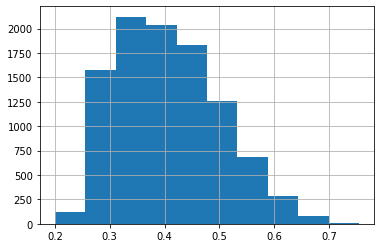

In [57]:
df_row_matches['sim'].hist()

In [ ]:
df_row_matches

In [42]:
df_row_matches

,index,matching_row_in_db2,company,address,name,level_0,noise_cmpny,noise_addr,noise_nm
0,0,6944,Norton-Castillo,"0751 Samantha Walk Apt. 650\nChenfort, SC 04033",Amanda Arroyo,6944,pastillo,ChenfortzSamjntca,a
1,1,3593,Bowman-Jensen,"787 Alexander Road\nPort Leslieborough, VA 53325",Victoria Brown,4394,Jenseu,er Vt,Vlctokia
2,3,3589,Simmons-Martinez,"7274 Bird Canyon Suite 720\nValentinechester, ...",Christopher Curtis,3589,Simmons,Bnrd Va6actinec5uster,Christopher
3,6,1472,Huffman Inc,"418 Jeremy Lock Apt. 900\nWolfemouth, OK 71462",David Adams,1472,Huffman,900 Jeremy,Adams
4,8,2633,Davis-Rodriguez,"752 Tami Flats\nPort Cesarstad, NM 22031",Michele Romero,2633,Rodr2guez,zami 2o031,Md3hele
...,...,...,...,...,...,...,...,...,...
9995,19989,2288,Hoffman Ltd,"90281 Hamilton Extension Suite 880\nCainside, ...",Cynthia Johnson,2288,lifmman,93447 vuite,Jrhnson
9996,19991,4623,"Singleton, Dunn and Shields","72558 Timothy Ridge Apt. 763\nJessestad, PA 26529",Nicholas Jensen,4623,funn,72558 Apt.,Jensen
9997,19992,5102,Harmon-Ramirez,"402 White Lodge Apt. 819\nMunozberg, CT 30161",Robert Bryant,5102,Harmon,ipt. 889,Bryant
9998,19996,9612,Harris-Murray,"40475 Carl Shores Suite 857\nAngelatown, MA 24891",Kristin Rowe,9612,Harris,2fdS2ores,Klistin
